In [1]:
!pip install torchsummary torch torchaudio pandas librosa pyACA soundfile numpy scipy sklearn tensorflow 

  Using cached pyACA-0.2.1-py3-none-any.whl (38 kB)
  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 10.3 MB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 112.1 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=dab62aa48c0c5345fa13f823f6eaf172edb7461e0c65adc0b741ba757bae61d0
  Stored in directory: /home/vedant/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [14]:
!pip install --force-reinstall numba==0.53

     |████████████████████████████████| 3.4 MB 3.7 MB/s 
  Using cached setuptools-58.3.0-py3-none-any.whl (946 kB)
  Using cached numpy-1.21.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached llvmlite-0.36.0-cp38-cp38-manylinux2010_x86_64.whl (25.3 MB)
ERROR: launchpadlib 1.10.13 requires testresources, which is not installed.
ERROR: tensorflow 2.6.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.3 which is incompatible.
ERROR: tensorflow 2.6.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: tensorflow 2.6.0 has requirement typing-extensions~=3.7.4, but you'll have typing-extensions 3.10.0.2 which is incompatible.
  Attempting uninstall: setuptools
    Found existing installation: setuptools 58.3.0
    Uninstalling setuptools-58.3.0:
      Successfully uninstalled setuptools-58.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.3
    Uninstalling numpy-1.21.3:
      Successfull

In [ ]:
import os
import pandas as pd
import librosa
import soundfile as sf
import numpy as np
import math
import scipy.io.wavfile, scipy.signal
from scipy.spatial import distance
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

lut=pd.read_csv('../resources/dataset/Annotations/final/annotation.csv')

# Pre-Processing Data
- Load Ground Truth from annotation.csv at 44.1kHz
- Load audio files for each song
    1. Average L+R to convert to mono audio
    2. Divide into 5 second windows with 1 second hop\
    3. Label each hop based on whether its midpoint is within the start and end times annotated 

In [16]:
# BLOCK AUDIO
def block_audio(x,blockSize,hopSize,fs):    
    # allocate memory    
    numBlocks = math.ceil(x.size / hopSize)    
    xb = np.zeros([numBlocks, blockSize])    
    # compute time stamps    
    t = (np.arange(0, numBlocks) * hopSize) / fs   
    t_mid = t + (0.5*blockSize/fs)
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)    
    for n in range(0, numBlocks):        
        i_start = n * hopSize        
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])        
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]    
    return (xb,t,t_mid)


## Labelling the blocks based on ground truth

In [17]:
lut=pd.read_csv('../resources/dataset/Annotations/final/annotation.csv')
i=0
for video_id in lut['video_id'].unique():
    fp='../resources/dataset/Audio/vocal_only/'+video_id+'_vocal.wav'
    #print(fp)
    x,sr = librosa.load(fp,sr=44100,mono=True)
    blockSize = int(sr * 1)
    hopSize = int(sr * 0.5)

    xb,t,t_mid = block_audio(x,blockSize,hopSize,sr)
    labels=[]
    for ts in t_mid:
        for idx,row in lut[lut['video_id'] == video_id].reset_index().iterrows():
            annotated_start = row['timestamp_start']
            annotated_end = row['timestamp_end']
            if annotated_start <= ts <= annotated_end:
                labels.append(row['scream_type'])
                break
        if ~(annotated_start <= ts <= annotated_end):
            labels.append('no_vocals')
    # Create new dataframs
    if i == 0:
        print("Creating dataframe")
        df=pd.DataFrame()

        df['t'] = t
        df['t_mid'] = t_mid
        blocks=[]
        for blk in xb:
            blocks.append(blk)
        df.insert(0,'video_id',video_id)
        df.insert(3,'label',labels)
        df['xb'] = blocks
        i+=1
    else:
        tmp=pd.DataFrame()
        tmp['t'] = t
        tmp['t_mid'] = t_mid
        blocks=[]
        for blk in xb:
            blocks.append(blk)
        tmp['video_id'] = video_id
        tmp['label'] = labels
        tmp['xb'] = blocks
        df=df.append(tmp)
out = df.to_numpy()
np.save('../resources/working_data/vocal_only_data.npy', out)
    #df.to_csv('./resources/working_data/'+video_id+'.csv',header=True, index=False,encoding='utf-8-sig',sep='\t')


Creating dataframe


# Extract Features
## 13 delta_mfccs, ZCR, Spectral Crest, Spectral Centroid
- Normalize the features across the entire dataset
- Extract mean, std dev of the feature value per block 
- Calculate change in feature from one block to another


In [ ]:
def block_audio(x,blockSize,hopSize,fs):    
    # allocate memory    
    numBlocks = math.ceil(x.size / hopSize)    
    xb = np.zeros([numBlocks, blockSize])    
    # compute time stamps    
    t = (np.arange(0, numBlocks) * hopSize) / fs   
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)    
    for n in range(0, numBlocks):        
        i_start = n * hopSize        
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])        
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]    
    return (xb,t)

def agg_mfccs(x):
    mfccs = librosa.feature.mfcc(x,n_mfcc = 13)
    mean = [np.mean(feature) for feature in mfccs]
    std = [np.std(feature) for feature in mfccs]
    mfcc_delta = librosa.feature.delta(mfccs)
    delta_mean=[np.mean(feature) for feature in mfcc_delta]
    delta_std=[np.std(feature) for feature in mfcc_delta]
    return mean,std,delta_mean,delta_std

def extract_features(x,fs=44100):
    #MFCCs
    mfcc_mean,mfcc_std,delta_mfcc_mean,delta_mfcc_std = agg_mfccs(x)
    #ZCR
    zcr=librosa.feature.zero_crossing_rate(x)
    #Spectral Centroid
    centroid = librosa.feature.spectral_centroid(x,44100)
    #Spectral Contrast
    contrast = librosa.feature.spectral_contrast(x,44100)
    #Spectral Flatness
    flatness = librosa.feature.spectral_flatness(x)
    #Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(x,44100)
    #RMS
    rms = librosa.feature.rms(x)
    
    return mfcc_mean,mfcc_std,delta_mfcc_mean,delta_mfcc_std,zcr,centroid,contrast,flatness,rolloff,rms

df=pd.DataFrame(np.load('../resources/working_data/vocal_only_data_with_vggish.npy',allow_pickle = True),columns=['video_id','start_time','mid_ts','label','audio','vggish'])

df['zcr'] = ''
df['average_zcr'] = ''
df['zcr_stddev'] = ''

#df['mfccs'] = ''
df['mfcc_mean'] = ''
df['mfcc_std'] = ''

df['delta_mfcc_mean'] = ''
df['delta_mfcc_std'] = ''

df['centroid'] = ''
df['centroid_mean']=''
df['centroid_std'] = ''

df['contrast'] = ''
df['contrast_mean']=''
df['contrast_std'] = ''

df['flatness'] = ''
df['flatness_mean']=''
df['flatness_std'] = ''

df['rolloff'] = ''
df['rolloff_mean']=''
df['rolloff_std'] = ''

df['rms'] = ''
df['rms_mean']=''
df['rms_std'] = ''

#Row wise (block wise) aggregation of features by mean and std dev
for i in range(len(df)):
    #audio = butter_bandpass_filter(df['audio'][i],200,4500,44100)
    #audio = df['audio'][i]
    mean, std, delta_mean, delta_std, zcr, centroid, contrast, flatness, rolloff,rms = extract_features(df['audio'][i],44100)
    # Calculate ZCR - mean and std
    df['zcr'][i] = zcr
    df['average_zcr'][i] = np.mean(zcr)
    df['zcr_stddev'][i] = np.std(zcr)
    # Extract 13 MFCCs - get mean and std deviation for each (26 features) + Delta MFCCs (26 features) = total 52 Features
    df['mfcc_mean'][i] = mean
    df['mfcc_std'][i] = std
    df['delta_mfcc_mean'][i] = delta_mean
    df['delta_mfcc_std'][i] = delta_std

    #Calculate Spectral Centroid Mean and Std
    df['centroid'][i] = centroid
    df['centroid_mean'][i]=np.mean(centroid)
    df['centroid_std'][i] = np.std(centroid)

    #Calculate Spectral Contrast - Mean and Std
    df['contrast'][i] = contrast
    df['contrast_mean'][i]=np.mean(contrast)
    df['contrast_std'][i] = np.std(contrast)

    #Calculate spectral flatness - mean and std
    df['flatness'][i] = flatness
    df['flatness_mean'][i] = np.mean(flatness)
    df['flatness_std'][i] = np.std(flatness)

    #Calculate spectral flatness - mean and std
    df['rolloff'][i] = rolloff
    df['rolloff_mean'][i] = np.mean(rolloff)
    df['rolloff_std'][i] = np.std(rolloff)

    #Calculate rms - mean and std
    df['rms'][i] = rms
    df['rms_mean'][i] = np.mean(rms)
    df['rms_std'][i] = np.std(rms)


df[['mfcc1_mean','mfcc2_mean','mfcc3_mean','mfcc4_mean','mfcc5_mean','mfcc6_mean','mfcc7_mean','mfcc8_mean','mfcc9_mean','mfcc10_mean','mfcc11_mean','mfcc12_mean','mfcc13_mean']]=pd.DataFrame(df.mfcc_mean.tolist(), index= df.index)
df[['mfcc1_std','mfcc2_std','mfcc3_std','mfcc4_std','mfcc5_std','mfcc6_std','mfcc7_std','mfcc8_std','mfcc9_std','mfcc10_std','mfcc11_std','mfcc12_std','mfcc13_std']]=pd.DataFrame(df.mfcc_std.tolist(), index= df.index)

df[['delta_mfcc1_mean','delta_mfcc2_mean','delta_mfcc3_mean','delta_mfcc4_mean','delta_mfcc5_mean','delta_mfcc6_mean','delta_mfcc7_mean','delta_mfcc8_mean','delta_mfcc9_mean','delta_mfcc10_mean','delta_mfcc11_mean','delta_mfcc12_mean','delta_mfcc13_mean']]=pd.DataFrame(df.delta_mfcc_mean.tolist(), index= df.index)
df[['delta_mfcc1_std','delta_mfcc2_std','delta_mfcc3_std','delta_mfcc4_std','delta_mfcc5_std','delta_mfcc6_std','delta_mfcc7_std','delta_mfcc8_std','delta_mfcc9_std','delta_mfcc10_std','delta_mfcc11_std','delta_mfcc12_std','delta_mfcc13_std']]=pd.DataFrame(df.delta_mfcc_std.tolist(), index= df.index)

selected_cols=['video_id', 'start_time', 'mid_ts', 'label', 'average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std','vggish']
np.save('../resources/working_data/vocal_only_features.npy', df[selected_cols].to_numpy())

# Classify!

In [19]:
import os
import pandas as pd
import librosa
import soundfile as sf
import numpy as np
import math
import scipy.io.wavfile, scipy.signal
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier



cols=['video_id', 'ts', 'mid_ts', 'label', 'average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std','vggish']

d=np.load('../resources/working_data/vocal_only_features.npy',allow_pickle=True)
df = pd.DataFrame(d,columns=cols)

lut = pd.read_csv('../resources/dataset/lookup_new.csv')

### VGGish processing

In [20]:
vgg=pd.DataFrame(df["vggish"].to_list())
cols=[]
for col in vgg.columns:
    cols.append(f"vggish_{col+1}")
vgg.columns= cols

In [21]:
cols=['video_id', 'ts', 'mid_ts', 'label', 'average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std']
for i in range(128):
    cols.append(f"vggish_{i+1}")

In [22]:
df=pd.concat([df, vgg], axis=1)
feature_df=df[cols]

In [24]:
!pip install imblearn

     |████████████████████████████████| 189 kB 3.6 MB/s 


## Undersampling data to even out class distribution

In [25]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='not minority',random_state=0)
from collections import Counter
X = feature_df[cols].to_numpy()
y=feature_df[['label']].to_numpy()

X_under, y_under = undersample.fit_resample(X, y)

undersampled_data = pd.DataFrame(X_under,columns=cols)
undersampled_data['label'] = y_under
undersampled_data

,video_id,ts,mid_ts,label,average_zcr,zcr_stddev,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,...,vggish_119,vggish_120,vggish_121,vggish_122,vggish_123,vggish_124,vggish_125,vggish_126,vggish_127,vggish_128
0,-2WqQY_xSSM,170.0,170.5,clean,0.079029,0.013053,-189.503776,206.294854,-97.415934,-1.505885,...,109.0,60.0,20.0,142.0,13.0,167.0,255.0,218.0,27.0,255.0
1,FNdC_3LR2AI,219.0,219.5,clean,0.031407,0.00892,-411.15477,189.961967,66.833366,19.346209,...,0.0,149.0,92.0,80.0,0.0,14.0,255.0,0.0,61.0,255.0
2,4600fGWcn9o,280.5,281.0,clean,0.043171,0.008926,-259.862115,117.961574,-48.594384,52.596798,...,112.0,119.0,64.0,211.0,61.0,58.0,230.0,0.0,45.0,255.0
3,get0cXOsSXg,80.0,80.5,clean,0.044832,0.00377,-339.360561,83.497913,-25.653152,-7.9201,...,0.0,232.0,238.0,148.0,117.0,215.0,207.0,28.0,215.0,255.0
4,74nTzbgDGWM,121.5,122.0,clean,0.117962,0.090615,-256.005722,136.614912,-104.303484,-11.822311,...,32.0,234.0,79.0,211.0,116.0,117.0,137.0,0.0,233.0,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,B7iIS91fMAc,117.0,117.5,no_vocals,0.06452,0.020594,-802.774922,78.86715,-23.590122,-25.774127,...,0.0,240.0,225.0,128.0,0.0,182.0,243.0,0.0,3.0,255.0
3326,ainbICPRV8Y,25.5,26.0,no_vocals,0.323871,0.035206,-942.420441,-21.156558,-19.957504,29.538438,...,47.0,219.0,103.0,121.0,103.0,81.0,168.0,145.0,68.0,255.0
3327,Bh_5ofa__pY,192.5,193.0,no_vocals,0.38137,0.034207,-832.679221,-85.070036,-27.147779,143.72803,...,23.0,51.0,107.0,105.0,57.0,131.0,180.0,66.0,0.0,255.0
3328,C_voh9WFbsM,193.0,193.5,no_vocals,0.37683,0.062925,-991.948038,-16.172109,2.334577,14.460796,...,47.0,216.0,102.0,116.0,103.0,88.0,174.0,151.0,71.0,255.0


In [28]:
! pip install matplotlib plotly nbformat

     |████████████████████████████████| 178 kB 3.6 MB/s 
     |████████████████████████████████| 69 kB 1.3 MB/s 
     |████████████████████████████████| 53 kB 405 kB/s 
     |████████████████████████████████| 118 kB 37.1 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Plot scatter plot of features

In [33]:
import plotly.express as px
fig = px.scatter_matrix(undersampled_data[['label', 'average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std','centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std']],dimensions=["average_zcr", "rms_mean", "mfcc1_mean", "delta_mfcc1_mean","flatness_std","flatness_std"],color='label')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [32]:
!pip install --upgrade nbformat

Requirement already up-to-date: nbformat in /home/vedant/.local/lib/python3.8/site-packages (5.1.3)


## Train-test split

In [34]:
from sklearn.model_selection import GroupShuffleSplit
train_inds, test_inds = next(GroupShuffleSplit(test_size=.2, n_splits=2, random_state = 0).split(lut, groups=lut['band_name']))

train = lut.iloc[train_inds]
test = lut.iloc[test_inds]

train_ids = train['video_id'].to_numpy()
test_ids = test['video_id'].to_numpy()

#df_final = df
df_final = undersampled_data
train = df_final[df_final.video_id.isin(train_ids)]
test = df_final[df_final.video_id.isin(test_ids)]

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Normalizing features and convert df to numpy array for input to classifier

In [44]:
selected_cols

['average_zcr',
 'zcr_stddev',
 'mfcc1_mean',
 'mfcc2_mean',
 'mfcc3_mean',
 'mfcc4_mean',
 'mfcc5_mean',
 'mfcc6_mean',
 'mfcc7_mean',
 'mfcc8_mean',
 'mfcc9_mean',
 'mfcc10_mean',
 'mfcc11_mean',
 'mfcc12_mean',
 'mfcc13_mean',
 'mfcc1_std',
 'mfcc2_std',
 'mfcc3_std',
 'mfcc4_std',
 'mfcc5_std',
 'mfcc6_std',
 'mfcc7_std',
 'mfcc8_std',
 'mfcc9_std',
 'mfcc10_std',
 'mfcc11_std',
 'mfcc12_std',
 'mfcc13_std',
 'delta_mfcc1_mean',
 'delta_mfcc2_mean',
 'delta_mfcc3_mean',
 'delta_mfcc4_mean',
 'delta_mfcc5_mean',
 'delta_mfcc6_mean',
 'delta_mfcc7_mean',
 'delta_mfcc8_mean',
 'delta_mfcc9_mean',
 'delta_mfcc10_mean',
 'delta_mfcc11_mean',
 'delta_mfcc12_mean',
 'delta_mfcc13_mean',
 'delta_mfcc1_std',
 'delta_mfcc2_std',
 'delta_mfcc3_std',
 'delta_mfcc4_std',
 'delta_mfcc5_std',
 'delta_mfcc6_std',
 'delta_mfcc7_std',
 'delta_mfcc8_std',
 'delta_mfcc9_std',
 'delta_mfcc10_std',
 'delta_mfcc11_std',
 'delta_mfcc12_std',
 'delta_mfcc13_std',
 'centroid_mean',
 'centroid_std',
 'contra

In [52]:
selected_cols=['average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std']
for i in range(128):
    selected_cols.append(f"vggish_{i+1}")


train = df_final[df_final.video_id.isin(train_ids)]
test = df_final[df_final.video_id.isin(test_ids)]

X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# kNN Classifier

## Classification for full bandwidth input

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

[[ 72   8   2   6   8   6]
 [ 12  48  14   6  29   4]
 [ 65  53  41  23  44   5]
 [ 34  43  17  26 123  25]
 [ 13  44  20  17  58   1]
 [ 13  20   6   7   7 130]]
0.37640824730786404


## 3 class problem: sing, scream, nothing

### KNN Classify 3 class problem

In [38]:
y_train_3class = []
y_test_3class = []
for i in range(len(y_train)):
    if y_train[i] in ['midfry','lowfry','highfry','layered']:
        y_train_3class.append('scream')
    elif y_train[i] == 'clean':
        y_train_3class.append('sing')
    else:
        y_train_3class.append('no vocal')

for i in range(len(y_test)):
    if y_test[i] in ['midfry','lowfry','highfry','layered']:
        y_test_3class.append('scream')
    elif y_test[i] == 'clean':
        y_test_3class.append('sing')
    else:
        y_test_3class.append('no vocal')

y_train_3class = np.array(y_train_3class)
y_test_3class = np.array(y_test_3class)

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
k=5
KNN_model = KNeighborsClassifier(n_neighbors=k)
KNN_model.fit(X_train, y_train_3class)
KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test_3class, KNN_prediction, average='macro')
cm = confusion_matrix(y_test_3class, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

[[ 89  82  12]
 [ 59 629  77]
 [ 43  59   0]]
0.4276172344235172


# SVM

## SVM Optimization

In [22]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
print("-------------------------------------------------------------------------------")
print("            SVM             ")
print("{'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'decision_function_shape': 'ovr', 'coef0': 3.2, 'C': 1.053646986645436}")
print("-------------------------------------------------------------------------------")

C = [x**0.01 for x in range(80,200,10)]
kernel = ['rbf','linear','poly','sigmoid']
degree = [int(x) for x in range(1,8)]
gamma = ['scale','auto']
coef0 = [x*0.1 for x in range(0,40)]
decision_function_shape = ['ovo','ovr']

svm_grid = { 'C' : C,
            'kernel' : kernel,
            'degree' : degree,
            'gamma' : gamma,
            'coef0' : coef0,
            'decision_function_shape' : decision_function_shape
            }

svc = SVC(random_state=42)
svm_df=pd.DataFrame()
svm_df['trial']=[]
svm_df['accuracy'] = []
svm_df['macro_accuracy'] = []
svm_df['confusion_matrix']=[]
svm_df['params']=[]
svm_df['cv_acc']=[]
svm_df['cv_std']=[]

trial=[]
accuracy=[]
macro_accuracy=[]
confusion=[]
params=[]
cv_acc=[]
cv_std=[]
for i in range(0,10):
    trial.append(i)
    svc_RandomGrid = RandomizedSearchCV(estimator = svc, param_distributions=svm_grid,cv=10,verbose=0,n_jobs=4) #verbose=2
    svc_RandomGrid.fit(X_train,y_train)
    #print(svc_RandomGrid.best_params_)
    params.append(svc_RandomGrid.best_params_)
    y_prediction = svc_RandomGrid.predict(X_test)
    score=precision_score(y_test, y_prediction, average='macro')
    acc = accuracy_score(y_test, y_prediction)
    cm = confusion_matrix(y_test, y_prediction) # clean, highfry, layered, lowfry, midfry, no vocals

    accuracy.append(acc)
    macro_accuracy.append(score)
    confusion.append(cm)
    scores = cross_validate(svc_RandomGrid, X_train, y_train, cv=5)
    cv_acc.append(scores['test_score'].mean())
    cv_std.append(scores['test_score'].std())
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))
    #print(f"Confusion Matrix:\n {cm}")
    #print(f"Accuracy score: {accuracy}")
    #print(f"Macro accuracy score: {score}")


svm_df['trial']= trial
svm_df['accuracy'] = accuracy
svm_df['macro_accuracy'] = macro_accuracy
svm_df['confusion_matrix']=confusion
svm_df['params']=params
svm_df['cv_acc']=cv_acc
svm_df['cv_std']=cv_std

svm_df['macro_accuracy'].max()

-------------------------------------------------------------------------------
            SVM             
{'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'decision_function_shape': 'ovr', 'coef0': 3.2, 'C': 1.053646986645436}
-------------------------------------------------------------------------------


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.73 (+/- 0.04)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.73 (+/- 0.07)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.73 (+/- 0.08)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.72 (+/- 0.06)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.72 (+/- 0.07)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.72 (+/- 0.06)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.72 (+/- 0.07)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.73 (+/- 0.06)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.73 (+/- 0.07)


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-pac

Accuracy: 0.73 (+/- 0.08)


0.4052356942757552

In [25]:
svm_df[svm_df['macro_accuracy'] == svm_df['macro_accuracy'].max()]

,trial,accuracy,macro_accuracy,confusion_matrix,params,cv_acc,cv_std
3,3,0.388571,0.405236,"[[72, 4, 5, 2, 9, 10], [12, 51, 4, 2, 42, 2], ...","{'kernel': 'poly', 'gamma': 'scale', 'degree':...",0.71886,0.030494


In [26]:
for val in svm_df.loc[3]:
    print(val)

3
0.38857142857142857
0.4052356942757552
[[ 72   4   5   2   9  10]
 [ 12  51   4   2  42   2]
 [ 43  57  49   8  64  10]
 [ 12  31  32   9 150  34]
 [  3  37  16   6  86   5]
 [  4  22   3   3  10 141]]
{'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'decision_function_shape': 'ovr', 'coef0': 2.1, 'C': 1.053301554301757}
0.718859649122807
0.03049428648380472


## SVM for full signal

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

SVM_model = SVC(gamma='scale',C=1.0533, kernel='poly', degree=2,coef0=2.1,random_state=42)
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

[[ 72   4   5   2   9  10]
 [ 12  51   4   2  42   2]
 [ 43  57  49   8  64  10]
 [ 12  31  32   9 150  34]
 [  3  37  16   6  86   5]
 [  4  22   3   3  10 141]]
0.4052356942757552


## 3 class SVM

In [54]:
SVM_model = make_pipeline(StandardScaler(),\
    SVC(gamma='auto',C=1.0, kernel='rbf', degree=3,random_state=None)\
        )
SVM_model.fit(X_train, y_train_3class)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test_3class, SVM_prediction, average='macro')
cm = confusion_matrix(y_test_3class, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

[[125  46  12]
 [ 67 664  34]
 [ 56  38   8]]
0.5132936469906741


# Random Forest

In [86]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

[[ 62   9   1   1  18  11]
 [ 23  39   9   2  34   6]
 [ 62  45  41  22  48  13]
 [ 75  15  21   2 123  32]
 [ 16  49  22   7  57   2]
 [ 13  12   1   0   6 151]]
0.31163499007278334


### RF 3 class problem

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',)
RF_model.fit(X_train, y_train_3class)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test_3class, RF_prediction, average='macro')
cm = confusion_matrix(y_test_3class, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

[[ 85  96   2]
 [ 25 739   1]
 [ 18  80   4]]
0.6810471148842051


# Experiment 1: Only 13 MFCCs for 6 class problem

## Results:
Classifier : Accuracy
- kNN : 0.20965138856600093
- SVM : 0.25948889017325344
- RF : 0.26579033320585255

In [87]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

selected_cols = ['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',\
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', \
       'mfcc8_mean','mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', \
       'mfcc12_mean','mfcc13_mean', 'mfcc1_std', \
       'mfcc2_std', 'mfcc3_std', 'mfcc4_std','mfcc5_std', \
       'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std','mfcc10_std', \
       'mfcc11_std', 'mfcc12_std', 'mfcc13_std']
#        ,'centroid_mean','centroid_std',\
#         'contrast_mean','contrast_std',\
#         'flatness_mean','flatness_std',\
#         'rolloff_mean','rolloff_std']
X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()

k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=1.0, kernel='rbf', degree=3,random_state=None))
RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced')

KNN_model.fit(X_train, y_train)
SVM_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)

print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")

KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 100, criterion=gini, \nmax_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
[[ 52  13   8  14   7   8]
 [ 18  34  20   3  36   2]
 [ 51  65  51  12  44   8]
 [ 38  23  26  14 152  15]
 [ 28  48  17  12  46   2]
 [  6  17   8   2   7 143]]
0.33970946871684654
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
[[ 57   3   2   0  21  19]
 [  9  47   9   4  41   3]
 [ 36  54  54   7  66  14]
 [ 23  20   6   9 175  35]
 [ 15  50  14   8  62   4]
 [  6  22   0   2   7 146]]
0.398800190958013
-------------------------------------------------------------------------------
            RF with n_estimators = 100, criterion=gini, 
max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',

# Experiment 2: 13 MFCCs + Delta MFCCs

## Results:
Classifier : Accuracy
- kNN : 0.21160954793326447
- SVM : 0.320572916667593
- RF : 0.2990929498490106

In [88]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

selected_cols = ['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',\
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', \
       'mfcc8_mean','mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', \
       'mfcc12_mean','mfcc13_mean', 'mfcc1_std', \
       'mfcc2_std', 'mfcc3_std', 'mfcc4_std','mfcc5_std', \
       'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std','mfcc10_std', \
       'mfcc11_std', 'mfcc12_std', 'mfcc13_std','delta_mfcc1_mean', \
       'delta_mfcc2_mean', 'delta_mfcc3_mean','delta_mfcc4_mean', \
       'delta_mfcc5_mean', 'delta_mfcc6_mean','delta_mfcc7_mean', \
       'delta_mfcc8_mean', 'delta_mfcc9_mean','delta_mfcc10_mean', \
       'delta_mfcc11_mean', 'delta_mfcc12_mean','delta_mfcc13_mean',\
       'delta_mfcc1_std', 'delta_mfcc2_std','delta_mfcc3_std', 'delta_mfcc4_std', \
       'delta_mfcc5_std','delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',\
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std','delta_mfcc12_std', \
       'delta_mfcc13_std']
X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()

k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=1.0, kernel='rbf', degree=3,random_state=None))
RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced')

KNN_model.fit(X_train, y_train)
SVM_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)

print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")

KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 100, criterion=gini, \nmax_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
[[ 52  13   8  14   7   8]
 [ 19  34  20   3  35   2]
 [ 51  65  51  12  44   8]
 [ 38  23  26  14 152  15]
 [ 28  49  16  11  47   2]
 [  6  17   8   2   7 143]]
0.3411456656341448
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
[[ 52   6   1   2  24  17]
 [ 10  51  12   2  35   3]
 [ 43  47  52   9  67  13]
 [ 35  20  16   8 153  36]
 [ 16  44  18   6  65   4]
 [  8  23   0   1   9 142]]
0.3732761303534969
-------------------------------------------------------------------------------
            RF with n_estimators = 100, criterion=gini, 
max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',

# Experiment 3: Librosa Features only

## Results:
Classifier : Accuracy
- kNN : 0.14598487359185544
- SVM : 0.20628745281990477
- RF : 0.3013805675780411

In [89]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

selected_cols = ['average_zcr','zcr_stddev',\
        'centroid_mean','centroid_std',\
       'contrast_mean','contrast_std',\
       'flatness_mean','flatness_std',\
       'rolloff_mean','rolloff_std']
X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()

k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=1.0, kernel='rbf', degree=3,random_state=None))
RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced')

KNN_model.fit(X_train, y_train)
SVM_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)

print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")

KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 100, criterion=gini, \nmax_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
[[ 34  17  15  10  19   7]
 [ 27  34  22   9  11  10]
 [ 75  60  42  15  35   4]
 [101  41  31  23  52  20]
 [ 43  36  25  11  36   2]
 [ 15  21  12   8  12 115]]
0.30205157453912523
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
[[ 69  10   2   1  10  10]
 [ 26  41  26   7  12   1]
 [ 51  61  67  10  37   5]
 [ 77  18  82  26  52  13]
 [ 18  69  17   7  41   1]
 [ 25  18   4   4   7 125]]
0.3872938246068271
-------------------------------------------------------------------------------
            RF with n_estimators = 100, criterion=gini, 
max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto'

# Experiment 4: All Features

## Results:
Classifier : Accuracy
- kNN : 0.15090983576491654
- SVM : 0.35187628931391995
- RF : 0.2962571928783088

In [93]:
cols=['average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std']
for i in range(128):
    cols.append(f"vggish_{i+1}")


import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


X_train = train[cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[cols].to_numpy()
y_test = test[['label']].to_numpy()

k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=1.0, kernel='rbf', degree=3,random_state=None))


KNN_model.fit(X_train, y_train)
SVM_model.fit(X_train, y_train)


print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")

KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 100, criterion=gini, \nmax_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced')
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
[[ 57  13   9   8   8   7]
 [ 26  46  10   9  19   3]
 [ 76  50  40  20  37   8]
 [ 86  52  33  23  54  20]
 [ 23  51  23  17  38   1]
 [ 18  14   3   7  12 129]]
0.3349467860023582
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
[[ 73   4   1   2  13   9]
 [ 13  50   4   2  38   6]
 [ 51  46  51   9  61  13]
 [ 14  35  28   3 150  38]
 [  3  35  17   4  89   5]
 [  7  19   3   1   8 145]]
0.37840255527773187
-------------------------------------------------------------------------------
            RF with n_estimators = 100, criterion=gini, 
max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto'

# Experiment 5: Tweaking SVM parameters

## Results:

Confusion Matrix:

[[ 47 - 1 - 0 - 1 - 39 - 14]  
[ 23 - 47 - 0 - 6 - 37 - 0]  
[106 - 56 - 2 - 3 - 62 - 2]  
[ 96 - 59 - 0 - 49 - 63 - 1]  
[ 47 - 22 - 1 - 0 - 82 - 1]  
[ 77 - 17 - 0 - 6 - 27 - 56]]  

Macro Accuracy:  
0.4655243070525728

In [94]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

X_train = train[cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[cols].to_numpy()
y_test = test[['label']].to_numpy()


print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=1.0, kernel='rbf', degree=3,random_state=0))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
#print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=0.855, kernel = linear, degree = 3              ")
print("-------------------------------------------------------------------------------")
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=0.855, kernel='linear', degree=3,random_state=0))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
#print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=0.855, kernel = poly, degree = 3              ")
print("-------------------------------------------------------------------------------")
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=0.855, kernel='poly', degree=3,random_state=0))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
#print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=0.855, kernel = sigmoid           ")
print("-------------------------------------------------------------------------------")
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=0.855, kernel='sigmoid', random_state=0))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
#print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            TEST - SVM with C=0.855, kernel = poly, degree = 3, gamma=scale              ")
print("-------------------------------------------------------------------------------")
SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto',C=0.855, kernel='poly', degree=3,random_state=0,decision_function_shape='ovr',shrinking=False))
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)





-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
0.37840255527773187
-------------------------------------------------------------------------------
            SVM with C=0.855, kernel = linear, degree = 3              
-------------------------------------------------------------------------------
0.39072162386801473
-------------------------------------------------------------------------------
            SVM with C=0.855, kernel = poly, degree = 3              
-------------------------------------------------------------------------------
0.35756760741280863
-------------------------------------------------------------------------------
            SVM with C=0.855, kernel = sigmoid           
-------------------------------------------------------------------------------
0.3746058264749137
----------------

# Experiment 6: Tweaking RF

In [95]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

X_train = train[cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[cols].to_numpy()
y_test = test[['label']].to_numpy()


print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 100, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=90,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 90, criterion=entropy, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=90,criterion='entropy',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 600, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=800,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(score)

-------------------------------------------------------------------------------
            RF with n_estimators = 100, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',
max_leaf_nodes=None,class_weight='balanced'              
-------------------------------------------------------------------------------
0.33039874145054005
-------------------------------------------------------------------------------
            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',
max_leaf_nodes=None,class_weight='balanced'              
-------------------------------------------------------------------------------
0.32920981827603124
-------------------------------------------------------------------------------
            RF with n_estimators = 90, criterion=entropy, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',
max_leaf_nodes=None,class_weight='balanced'    

# Experiments with Optimized Classifiers

Done using hyperparameters optimized for the entire feature-set

## All Features

-------------------------------------------------------------------------------
            SVM with C=0.855, kernel = linear, degree = 3              
-------------------------------------------------------------------------------
Overall Accuracy Score: 0.3619047619047619
Confusion Matrix
Class-wise accuracy:
[0.56862745 0.07843137 0.1372549  0.03921569 0.08823529 0.08823529]
[0.07079646 0.4159292  0.08849558 0.03539823 0.36283186 0.02654867]
[0.18181818 0.25108225 0.21645022 0.08658009 0.1991342  0.06493506]
[0.04104478 0.1119403  0.1641791  0.09328358 0.48880597 0.10074627]
[0.05882353 0.24836601 0.15686275 0.05882353 0.44444444 0.03267974]
[0.04371585 0.12021858 0.02185792 0.01639344 0.07650273 0.72131148]
Macro Accuracy: 0.38270717020504663
-------------------------------------------------------------------------------
            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',
max_leaf_nodes=None,class_weight

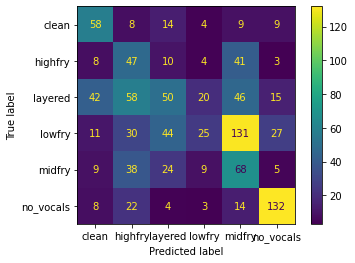

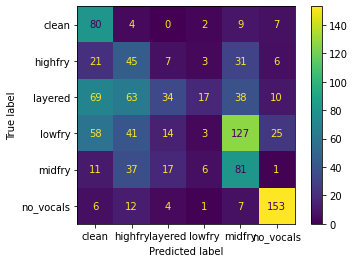

In [77]:
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

selected_cols=['average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std','rms_mean','rms_std']
for i in range(128):
    selected_cols.append(f"vggish_{i+1}")

train = df_final[df_final.video_id.isin(train_ids)]
test = df_final[df_final.video_id.isin(test_ids)]

X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()

scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print("-------------------------------------------------------------------------------")
print("            SVM with C=0.855, kernel = linear, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_model = SVC(gamma='auto',C=0.855, kernel='linear',random_state=42)
SVM_model.fit(X_train, y_train)

SVM_prediction = SVM_model.predict(X_test)
acc = accuracy_score(y_test, SVM_prediction)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Overall Accuracy Score: {acc}")
print("Confusion Matrix")
#print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SVM_model.classes_).plot()
print("Class-wise accuracy:")
for row in cm:
    print(row/row.sum())
print(f"Macro Accuracy: {score}")

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=90,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
acc = accuracy_score(y_test, RF_prediction)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(f"Overall Accuracy Score: {acc}")
print("Confusion Matrix:")
#print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=RF_model.classes_).plot()
print("Class-wise accuracy:")
for row in cm:
    print(row/row.sum())
print(f"Macro Accuracy: {score}")

## MFCCs + Delta MFCCs Only

In [29]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

selected_cols = ['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',\
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', \
       'mfcc8_mean','mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', \
       'mfcc12_mean','mfcc13_mean', 'mfcc1_std', \
       'mfcc2_std', 'mfcc3_std', 'mfcc4_std','mfcc5_std', \
       'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std','mfcc10_std', \
       'mfcc11_std', 'mfcc12_std', 'mfcc13_std','delta_mfcc1_mean', \
       'delta_mfcc2_mean', 'delta_mfcc3_mean','delta_mfcc4_mean', \
       'delta_mfcc5_mean', 'delta_mfcc6_mean','delta_mfcc7_mean', \
       'delta_mfcc8_mean', 'delta_mfcc9_mean','delta_mfcc10_mean', \
       'delta_mfcc11_mean', 'delta_mfcc12_mean','delta_mfcc13_mean',\
       'delta_mfcc1_std', 'delta_mfcc2_std','delta_mfcc3_std', 'delta_mfcc4_std', \
       'delta_mfcc5_std','delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',\
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std','delta_mfcc12_std', \
       'delta_mfcc13_std']
X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()





print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")

k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_model = SVC(gamma='scale',C=1.0533, kernel='poly', degree=2,coef0=2.1,random_state=42)
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=90,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=42)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
[[ 52  13   8  14   7   8]
 [ 19  34  20   3  35   2]
 [ 51  65  51  12  44   8]
 [ 38  23  26  14 152  15]
 [ 28  49  16  11  47   2]
 [  6  17   8   2   7 143]]
0.3411456656341448
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
[[ 48  13   3   1  23  14]
 [ 11  39  12   3  46   2]
 [ 35  56  73  11  49   7]
 [ 22  14  26   9 179  18]
 [ 14  47  18   8  65   1]
 [  6  26   0   1   6 144]]
0.38825378923297826
-------------------------------------------------------------------------------
            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',


## Centroid, ZCR, Contrast, Roll-off, Flatness

In [30]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

selected_cols = ['average_zcr','zcr_stddev',\
        'centroid_mean','centroid_std',\
        'contrast_mean','contrast_std',\
        'flatness_mean','flatness_std',\
        'rolloff_mean','rolloff_std']
X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()





print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")

k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_model = SVC(gamma='scale',C=1.0533, kernel='poly', degree=2,coef0=2.1,random_state=42)
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=90,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=42)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
[[ 34  17  15  10  19   7]
 [ 27  34  22   9  11  10]
 [ 75  60  42  15  35   4]
 [101  41  31  23  52  20]
 [ 43  36  25  11  36   2]
 [ 15  21  12   8  12 115]]
0.30205157453912523
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------


/Users/vedant/Desktop/Programming/scream-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 23  42   0   0  33   4]
 [ 24  74   0   0  13   2]
 [ 58 125   1   0  45   2]
 [129  82   0   0  41  16]
 [ 19  87   0   0  45   2]
 [ 18  35   2   0  14 114]]
0.2723973542333055
-------------------------------------------------------------------------------
            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',
max_leaf_nodes=None,class_weight='balanced'              
-------------------------------------------------------------------------------
[[ 58  11   3   9  10  11]
 [ 35  30  21   9  16   2]
 [ 66  39  60  15  38  13]
 [118  11  51  20  60   8]
 [ 21  45  29  10  44   4]
 [ 21  15   6   6  10 125]]
0.3395586840535678


## VGGish only

In [32]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

selected_cols = []
for i in range(128):
    selected_cols.append(f"vggish_{i+1}")

X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()





print("-------------------------------------------------------------------------------")
print("            KNN with k=4              ")
print("-------------------------------------------------------------------------------")

k=4
KNN_model = KNeighborsClassifier(n_neighbors=k)
KNN_model.fit(X_train, y_train)
KNN_prediction = KNN_model.predict(X_test)
score=precision_score(y_test, KNN_prediction, average='macro')
cm = confusion_matrix(y_test, KNN_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            SVM with C=1, kernel = rbf, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_model = SVC(gamma='scale',C=1.0533, kernel='poly', degree=2,coef0=2.1,random_state=42)
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=90,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=42)
RF_model.fit(X_train, y_train)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test, RF_prediction, average='macro')
cm = confusion_matrix(y_test, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            KNN with k=4              
-------------------------------------------------------------------------------
[[ 65   9   7   4   7  10]
 [ 11  49   9   8  30   6]
 [ 63  57  38  20  39  14]
 [ 30  45  40  20  91  42]
 [  6  47  17  17  61   5]
 [  4  21   5   6  11 136]]
0.34433690399837613
-------------------------------------------------------------------------------
            SVM with C=1, kernel = rbf, degree = 3              
-------------------------------------------------------------------------------
[[ 70   7   5   3  10   7]
 [  8  48   7   2  33  15]
 [ 55  45  39  13  55  24]
 [ 11  35  44   3 131  44]
 [  6  35  21   9  78   4]
 [  7  17   4   1  10 144]]
0.32923622621326154
-------------------------------------------------------------------------------
            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',

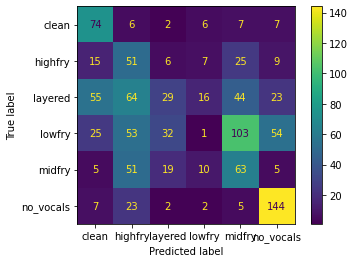

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SVM_model.classes_).plot()

# SVM Best results:

0.4052356942757552


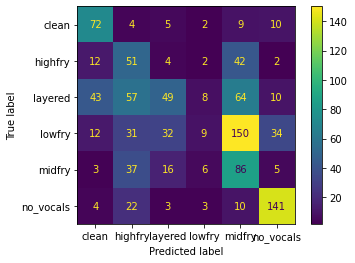

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


selected_cols=['average_zcr',
       'zcr_stddev', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc1_std', 'mfcc2_std', 'mfcc3_std', 'mfcc4_std',
       'mfcc5_std', 'mfcc6_std', 'mfcc7_std', 'mfcc8_std', 'mfcc9_std',
       'mfcc10_std', 'mfcc11_std', 'mfcc12_std', 'mfcc13_std',
       'delta_mfcc1_mean', 'delta_mfcc2_mean', 'delta_mfcc3_mean',
       'delta_mfcc4_mean', 'delta_mfcc5_mean', 'delta_mfcc6_mean',
       'delta_mfcc7_mean', 'delta_mfcc8_mean', 'delta_mfcc9_mean',
       'delta_mfcc10_mean', 'delta_mfcc11_mean', 'delta_mfcc12_mean',
       'delta_mfcc13_mean', 'delta_mfcc1_std', 'delta_mfcc2_std',
       'delta_mfcc3_std', 'delta_mfcc4_std', 'delta_mfcc5_std',
       'delta_mfcc6_std', 'delta_mfcc7_std', 'delta_mfcc8_std',
       'delta_mfcc9_std', 'delta_mfcc10_std', 'delta_mfcc11_std',
       'delta_mfcc12_std', 'delta_mfcc13_std',
       'centroid_mean','centroid_std',
       'contrast_mean','contrast_std',
       'flatness_mean','flatness_std',
       'rolloff_mean','rolloff_std']
for i in range(128):
    selected_cols.append(f"vggish_{i+1}")

train = df_final[df_final.video_id.isin(train_ids)]
test = df_final[df_final.video_id.isin(test_ids)]

X_train = train[selected_cols].to_numpy()
y_train=train[['label']].to_numpy()

X_test = test[selected_cols].to_numpy()
y_test = test[['label']].to_numpy()

scaler = StandardScaler()

X_train=scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

SVM_model = SVC(gamma='scale',C=1.0533, kernel='poly', degree=2,coef0=2.1,random_state=42)
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test, SVM_prediction, average='macro')
cm = confusion_matrix(y_test, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals

print(score)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SVM_model.classes_).plot()

In [41]:
cm

array([[ 72,   4,   5,   2,   9,  10],
       [ 12,  51,   4,   2,  42,   2],
       [ 43,  57,  49,   8,  64,  10],
       [ 12,  31,  32,   9, 150,  34],
       [  3,  37,  16,   6,  86,   5],
       [  4,  22,   3,   3,  10, 141]])

In [42]:
for row in cm:
    print(row/sum(row))

[0.70588235 0.03921569 0.04901961 0.01960784 0.08823529 0.09803922]
[0.10619469 0.45132743 0.03539823 0.01769912 0.37168142 0.01769912]
[0.18614719 0.24675325 0.21212121 0.03463203 0.27705628 0.04329004]
[0.04477612 0.11567164 0.11940299 0.03358209 0.55970149 0.12686567]
[0.01960784 0.24183007 0.10457516 0.03921569 0.5620915  0.03267974]
[0.02185792 0.12021858 0.01639344 0.01639344 0.05464481 0.7704918 ]


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, SVM_prediction, target_names=SVM_model.classes_, digits=4))

              precision    recall  f1-score   support

       clean     0.4932    0.7059    0.5806       102
     highfry     0.2525    0.4513    0.3238       113
     layered     0.4495    0.2121    0.2882       231
      lowfry     0.3000    0.0336    0.0604       268
      midfry     0.2382    0.5621    0.3346       153
   no_vocals     0.6980    0.7705    0.7325       183

    accuracy                         0.3886      1050
   macro avg     0.4052    0.4559    0.3867      1050
weighted avg     0.4069    0.3886    0.3465      1050



# 2 class - Vocal Only Test

In [67]:
X_train.shape

(2280, 192)

In [66]:
y_train.shape

(2280, 1)

In [65]:
y_test_2class.shape

(1050,)

In [64]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

y_train_2class = []
y_test_2class = []
for i in range(y_train.shape[0]):
    if y_train[i] in ['midfry','lowfry','highfry','layered','clean']:
        y_train_2class.append('vocal')
    else:
        y_train_2class.append('no vocal')

for i in range(y_test.shape[0]):
    if y_test[i] in ['midfry','lowfry','highfry','layered','clean']:
        y_test_2class.append('vocal')
    else:
        y_test_2class.append('no vocal')

y_train_2class = np.array(y_train_2class)
y_test_2class = np.array(y_test_2class)


In [68]:
print("-------------------------------------------------------------------------------")
print("            SVM with C=0.855, kernel = linear, degree = 3              ")
print("-------------------------------------------------------------------------------")

SVM_model = SVC(gamma='auto',C=0.855, kernel='linear',random_state=42)
SVM_model.fit(X_train, y_train_2class)

SVM_prediction = SVM_model.predict(X_test)
score=precision_score(y_test_2class, SVM_prediction, average='macro')
cm = confusion_matrix(y_test_2class, SVM_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

print("-------------------------------------------------------------------------------")
print("            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',\nmax_leaf_nodes=None,class_weight='balanced'              ")
print("-------------------------------------------------------------------------------")

RF_model = RandomForestClassifier(n_estimators=90,criterion='gini',max_depth=None,\
    min_samples_split=2,min_samples_leaf=1,max_features='auto',max_leaf_nodes=None,class_weight='balanced',random_state=0)
RF_model.fit(X_train, y_train_2class)
RF_prediction = RF_model.predict(X_test)
score=precision_score(y_test_2class, RF_prediction, average='macro')
cm = confusion_matrix(y_test_2class, RF_prediction) # clean, highfry, layered, lowfry, midfry, no vocals
print(cm)
print(score)

-------------------------------------------------------------------------------
            SVM with C=0.855, kernel = linear, degree = 3              
-------------------------------------------------------------------------------
[[135  48]
 [ 60 807]]
0.8180836707152497
-------------------------------------------------------------------------------
            RF with n_estimators = 90, criterion=gini, max_depth=None, min_samples_split=2,min_samples_leaf=1,max_features='auto',
max_leaf_nodes=None,class_weight='balanced'              
-------------------------------------------------------------------------------
[[134  49]
 [ 28 839]]
0.8859901568234901
